**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle
%matplotlib inline


In [2]:
# image space converter
def convert_image(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    return feature_image
        

# Define a function to return HOG features and visualization
# borrowed from udacity course tutorial
def get_hog_features(img, orient=9, pix_per_cell=2, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to compute binned color features  
# Borrowed form udacity course tutorial
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    ch1_features = cv2.resize(img[:,:,0], size).ravel() 
    ch2_features = cv2.resize(img[:,:,1], size).ravel() 
    ch3_features = cv2.resize(img[:,:,2], size).ravel() 
    features = np.hstack((ch1_features,ch2_features, ch3_features))
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# unless png data read by mpimg has been scaled back to 0-255
# Borrowed from udacity coruse tutorial
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# Assumes image has RGB which is the default order when img is read
# using mpimg
# Borrowed from 
def extract_features(imgs, color_space='RGB', hog_space='RGB', img_type='JPG', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        if img_type == 'PNG': # PNG images read by mpimg are in range 0-1. 
            image = (image*255).astype(np.uint8)
            #image = image.astype(np.float32)/255 # Need to be scaled to 0-1
        # apply color conversion if other than 'RGB'
        feature_image = convert_image(image, color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)

        
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            hog_feature_image = convert_image(image, hog_space)

            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(hog_feature_image.shape[2]):
                    hog_features.append(get_hog_features(hog_feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(hog_feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    


In [3]:
# Extract features from dataset

def train_model(color_space='RGB', hog_space = 'RGB', img_type='PNG', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    t=time.time()

    #load files with sample images
    car_images = glob.glob('./dataset/vehicles/**/*.png', recursive=True)
    cars = []
    for image in car_images:
        cars.append(image)

    notcar_images = glob.glob('./dataset/non-vehicles/**/*.png', recursive=True)
    notcars = []
    for image in notcar_images:
        notcars.append(image)

    #extract features
    car_features = extract_features(cars, color_space=color_space, hog_space = hog_space, img_type= img_type, 
                            spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    notcar_features = extract_features(notcars, color_space=color_space, hog_space = hog_space, img_type= img_type, 
                            spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    t2 = time.time()

    print(round(t2-t, 2), 'Seconds to extract features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using spatial binning of:',spatial_size,
        'and', hist_bins,'histogram bins and hog with orientation of:', orient, 
        'pix_per_cell:', pix_per_cell, 'cell_per_block:', cell_per_block,
         'hog_channels:', hog_channel)

    print('Feature vector length:', len(X_train[0]))

    # Use a linear SVC 
    svc = LinearSVC()

    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')

    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    return X_scaler, svc

In [4]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    # modified the sample function as it works only for overlap = 0.5
    nx_windows = np.int((xspan-xy_window[0])/nx_pix_per_step) + 1
    ny_windows = np.int((yspan-xy_window[1])/ny_pix_per_step) + 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def get_all_slide_windows(img, x_start_stop_list, y_start_stop_list, xy_window_list, xy_overlap_list):
    window_list =[]
    for i in range(len(x_start_stop_list)):
        window_list += slide_window(img, x_start_stop=x_start_stop_list[i], 
                                       y_start_stop=y_start_stop_list[i], 
                                       xy_window=xy_window_list[i], 
                                       xy_overlap=xy_overlap_list[i])
    return window_list


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
# TODO: Implement logic to take hog only once and then sub sample for each window 
def single_img_features(img, color_space='RGB', hog_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_space != 'RGB':
            if hog_space == 'HSV':
                hog_feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif hog_space == 'LUV':
                hog_feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif hog_space == 'HLS':
                hog_feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif hog_space == 'YUV':
                hog_feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif hog_space == 'YCrCb':
                hog_feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: hog_feature_image = np.copy(img)      

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(hog_feature_image.shape[2]):
                hog_features.extend(get_hog_features(hog_feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(hog_feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows_old(img, windows, clf, scaler, color_space='RGB', hog_space='RGB',
                    spatial_size=(32, 32), hist_bins=32, 
                    orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))   
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, hog_space=hog_space,
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows




# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, clf, scaler, color_space='RGB', hog_space = 'RGB',
                    window_scales = [1.0, 1.5], spatial_size=(32, 32), hist_bins=32, 
                    orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    
    #1) subset image to fixed lower size
    ytop=400
    ybot=656
    window_size=64 
    cells_per_step = 2
    pixels_per_step = cells_per_step*pix_per_cell #16
    sub_img = img[ytop:ybot, :, :]
    imshape = sub_img.shape

    #3) Create an empty list to receive positive detection windows
    on_windows = []
    all_windows = []
    
    
    for scale in window_scales:
        #scale the image 
        # scale of 1 will mean window of size 64
        # scale of 1.5 will mean window of size 96 and so on
        scaled_image = cv2.resize(sub_img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        scaled_imshape = scaled_image.shape
        #print (scale, scaled_imshape)

        #print(scaled_imshape[1])
        #print(pixels_per_step)
        #print(window_size)
        feature_image = convert_image(scaled_image, color_space)
        hog_image = convert_image(scaled_image, hog_space)
        
        #4) Calculate no. of steps in each direction 
        nx_step = (scaled_imshape[1]-window_size) // (pixels_per_step) + 1 #(1280-64)/16+1 = 77
        ny_step = (scaled_imshape[0]-window_size) // (pixels_per_step) + 1
    
        #5) get hog for the entire image
        if hog_feat:
            hog_output = []
            for channel in range(hog_image.shape[2]):
                hog_output.append(get_hog_features(hog_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=False))      
    
        #6) extract features for each window
        for x in range(nx_step):
            for y in range(ny_step):
                #6a) calculate window pixels 
                x_start = x*pixels_per_step # for x = 5, x_start = 5*16=80
                x_stop = x_start + window_size #80+64 = 144
                y_start = y*pixels_per_step
                y_stop = y_start+window_size
                
                #get bounding box
                bbox= (( np.int(x_start*scale),  #80
                         np.int((y_start)*scale+ytop)
                       ), 
                       ( np.int(x_stop*scale), #144
                         np.int((y_stop)*scale+ytop)
                       )
                      )
                
                #add this bbox to all_windows
                all_windows.append(bbox)

                # Now we extract features and run classfier on this window
                #define empty array to hold features
                img_features = []
                #6b) get the windowed image
                test_img = cv2.resize(feature_image[y_start:y_stop, x_start:x_stop], (64, 64))
                #6c) Compute spatial features if flag is set
                if spatial_feat == True:
                    spatial_features = bin_spatial(test_img, size=spatial_size)
                    img_features.append(spatial_features)
                #6d) Compute histogram features if flag is set
                if hist_feat == True:
                    hist_features = color_hist(test_img, nbins=hist_bins)
                    img_features.append(hist_features)
                #6e) get HOG features if flag is set
                if hog_feat == True:
                    hog_x_cell_start = x*cells_per_step #5*2 = 10
                    hog_x_cell_stop = hog_x_cell_start + window_size//pix_per_cell-cell_per_block+1 # 10+64/8-2+1 = 17
                    hog_y_cell_start = y*cells_per_step 
                    hog_y_cell_stop = hog_y_cell_start + window_size//pix_per_cell-cell_per_block+1
                    #print(hog_x_cell_start, hog_x_cell_stop, hog_y_cell_start, hog_y_cell_stop)
                    if hog_channel == 'ALL':
                        hog_features = []
                        for channel in range(hog_image.shape[2]):
                            hog_features.append(hog_output[channel][hog_y_cell_start:hog_y_cell_stop, hog_x_cell_start:hog_x_cell_stop].ravel())
                        hog_features = np.ravel(hog_features)        
                    else:
                        hog_features = hog_output[hot_channel][hog_y_cell_start:hog_y_cell_stop, hog_x_cell_start:hog_x_cell_stop].ravel()

                    #for channel in hog_channel:
                    #    #print (hog_output[channel][hog_y_cell_start:hog_y_cell_stop, hog_y_cell_start:hog_y_cell_stop].shape)
                    #   hog_features.extend(hog_output[channel][hog_y_cell_start:hog_y_cell_stop, hog_y_cell_start:hog_y_cell_stop].ravel())      

                    #6f) Append features to list
                    img_features.append(hog_features)

                #print(len(img_features))
                features = np.concatenate(img_features)
                #print(features.shape)

                #7) Scale extracted features to be fed to classifier
                test_features = scaler.transform(np.array(features).reshape(1, -1))
                #8) Predict using your classifier
                prediction = clf.predict(test_features)
                #9) If positive (prediction == 1) then save the window
                if prediction == 1:
                    on_windows.append(bbox)
                    #plt.figure()
                    #plt.imshow(test_img)
                
    #8) Return windows for positive detections
    return all_windows, on_windows


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [5]:
def get_heat(img, bbox_list):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold=2):
    # Zero out pixels below the threshold
    result = np.copy(heatmap)
    result[result <= threshold] = 0
    # Return thresholded map
    return result

def draw_labeled_bboxes(img, heatmap, color=(0, 0, 255), thick=6):
    # Iterate through all detected cars
    result_img = np.copy(img)
    labels = label(heatmap)
    bboxes=[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(result_img, bbox[0], bbox[1], color, thick)
        bboxes.append(bbox)
    # Return the image
    return result_img, bboxes


class TrackHeatMaps:
        def __init__(self, n=5):
            self.n = n
            self.last_n_frames = [np.zeros((720,1280)) for i in range(self.n)]
            
        def add_row(self,row):
            self.last_n_frames = self.last_n_frames[1:]
            self.last_n_frames.append(np.copy(row))



In [9]:
def visualize_plots(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        #plt.title(i+1)
        if len(img.shape) < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
            

In [7]:
def pipeline(img, clf, scaler, color_space='RGB', hog_space='RGB', img_type='JPG',
                    track_frames = False, window_scales=[1], spatial_size=(32, 32), hist_bins=32, 
                    orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True, color=(0,0,255), thick=6, threshold=2, visualize=True):

    # trackmaps is a global variable
    global trackmaps
    
    # check if image needs scaling based on img_type
    result_img = np.copy(img)
    if img_type == 'PNG':
        result_img = (result_img*255).astype(np.uint8)
        #result_img = result_img.astype(np.float32)/255 # Need to be scaled to 0-1 
    # search over all windows, extracting the image for window region and then run classifier to check
    # if window is hot
    all_windows, hot_windows = search_windows(result_img, clf=clf, scaler=scaler, color_space=color_space, hog_space=hog_space,
                        window_scales=window_scales, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    heatmap = get_heat(img, hot_windows)
    if track_frames:
        trackmaps.add_row(heatmap)
        # get heatmap for hot windows across frames
        for h_map in trackmaps.last_n_frames:
            heatmap+= h_map
    
    #apply threholding to remove False Positives
    thresholded_heatmap = apply_threshold(heatmap, threshold=threshold)

    #draw labeled boxes to merge multiple detections into a single rectangle
    labeled_image, labeled_boxes = draw_labeled_bboxes(np.copy(img), thresholded_heatmap, color=color, thick=thick)

    if visualize:
        # all boxes_image
        all_boxes_image = draw_boxes(np.copy(img), all_windows, color=color, thick=thick)

        # draw boxes before merging and thresholding
        hot_boxed_image = draw_boxes(np.copy(img), hot_windows, color=color, thick=thick)
        images = [img, hot_boxed_image, get_heat(img, hot_windows), heatmap, thresholded_heatmap, labeled_image] 
        titles = ['Original Image', 'Positive regions', 'Frame Heatmap', 
                  'Cumulative Heatmap(5 frame rolling)', 'Cumulative Heatmap thresholded' ,
                  'Final Image']
        #images = [img, hot_boxed_image] 
        #titles = ['Orginal image', 'Detected Windows']
        fig = plt.figure(figsize=(20,15))
        visualize_plots(fig, 3, 2, images, titles)
        
    return labeled_image

def process_img(img):
    #print(track_frames)
    labeled_image = pipeline(
                    img, clf=model, scaler=scaler, color_space=color_space, 
                    hog_space=hog_space, img_type='JPG',
                    track_frames=track_frames, window_scales=window_scales,
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat, color=color, thick=thick, threshold=threshold, visualize=visualize)
    return labeled_image




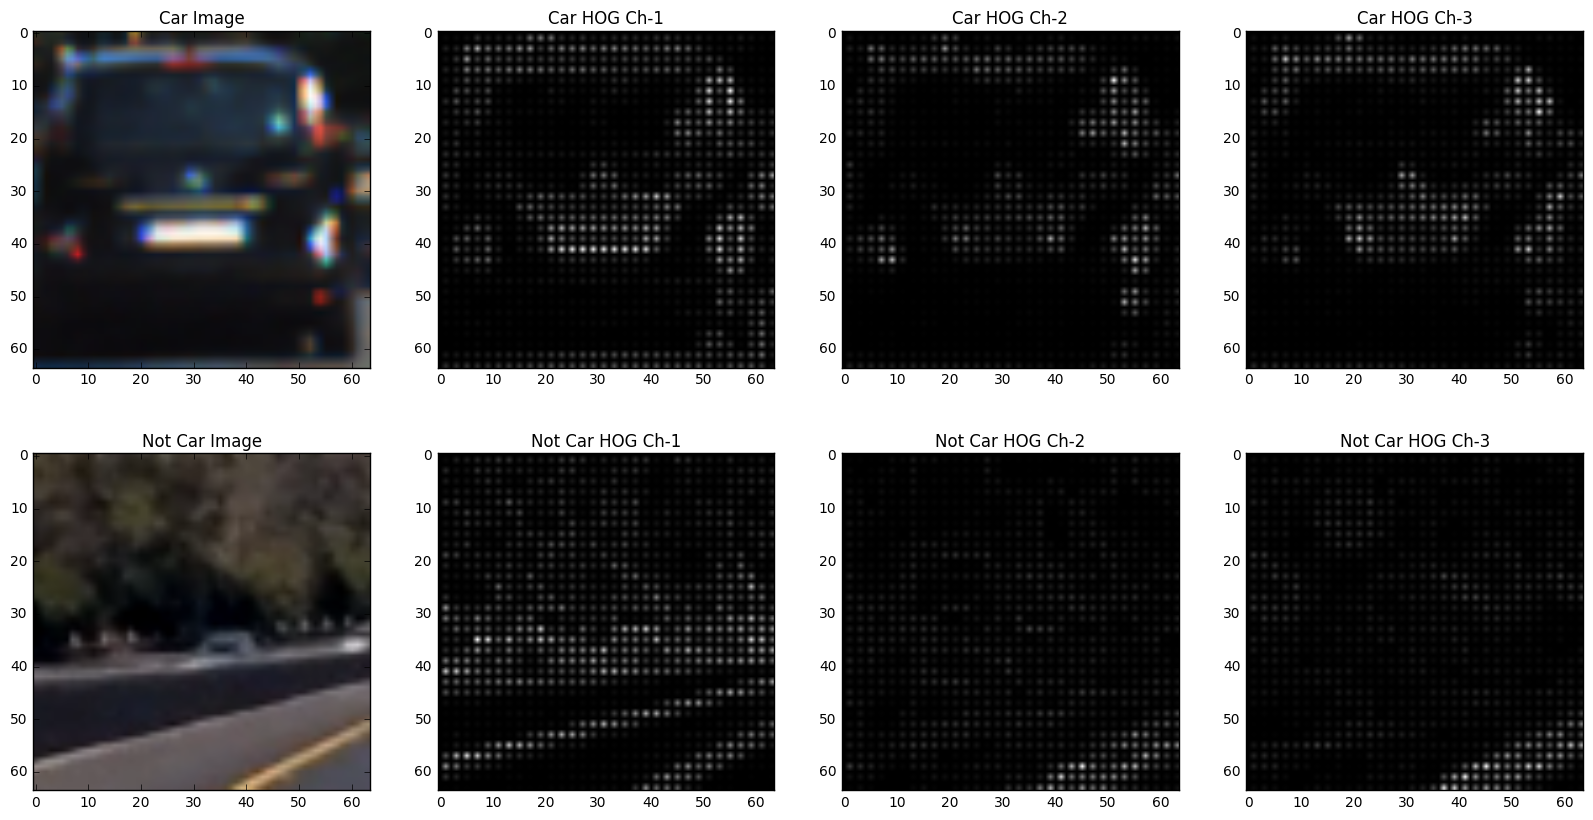

In [8]:
# HOG space exploration
import random
car_images = glob.glob('./dataset/vehicles/**/*.png', recursive=True)
car_random = random.choice(car_images)
notcar_images = glob.glob('./dataset/non-vehicles/**/*.png', recursive=True)
notcar_random = random.choice(notcar_images)

car_img = mpimg.imread(car_random)
notcar_img = mpimg.imread(notcar_random)
car_img_ycrcb = convert_image(car_img,'YCrCb')
notcar_img_ycrcb = convert_image(notcar_img,'YCrCb')

feat_car, hog_car1 = get_hog_features(car_img_ycrcb[:,:,0], vis=True)
feat_notcar, hog_notcar1 = get_hog_features(notcar_img_ycrcb[:,:,0], vis=True)
feat_car, hog_car2 = get_hog_features(car_img_ycrcb[:,:,1], vis=True)
feat_notcar, hog_notcar2 = get_hog_features(notcar_img_ycrcb[:,:,1], vis=True)
feat_car, hog_car3 = get_hog_features(car_img_ycrcb[:,:,2], vis=True)
feat_notcar, hog_notcar3 = get_hog_features(notcar_img_ycrcb[:,:,2], vis=True)

imgs = [car_img, hog_car1, hog_car2, hog_car3, notcar_img, hog_notcar1, hog_notcar2, hog_notcar3]
titles = ['Car Image', 'Car HOG Ch-1','Car HOG Ch-2','Car HOG Ch-3','Not Car Image', 
          'Not Car HOG Ch-1','Not Car HOG Ch-2','Not Car HOG Ch-3']
fig = plt.figure(figsize=(20,10))
visualize_plots(fig, 2, 4, imgs, titles)


In [10]:
# Parameters to tune for training classifier
spatial_size = (32,32)
hist_bins = 32
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

spatial_feat=True
hist_feat=True
hog_feat=True


In [11]:
scaler, model = train_model( color_space=color_space, hog_space = hog_space, img_type= 'PNG', 
                            spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)



93.06 Seconds to extract features...
Using spatial binning of: (32, 32) and 32 histogram bins and hog with orientation of: 9 pix_per_cell: 8 cell_per_block: 2 hog_channels: ALL
Feature vector length: 8460
8.52 Seconds to train SVC...
Test Accuracy of SVC =  0.9901
My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  1.  1.  0.  1.]
0.0 Seconds to predict 10 labels with SVC


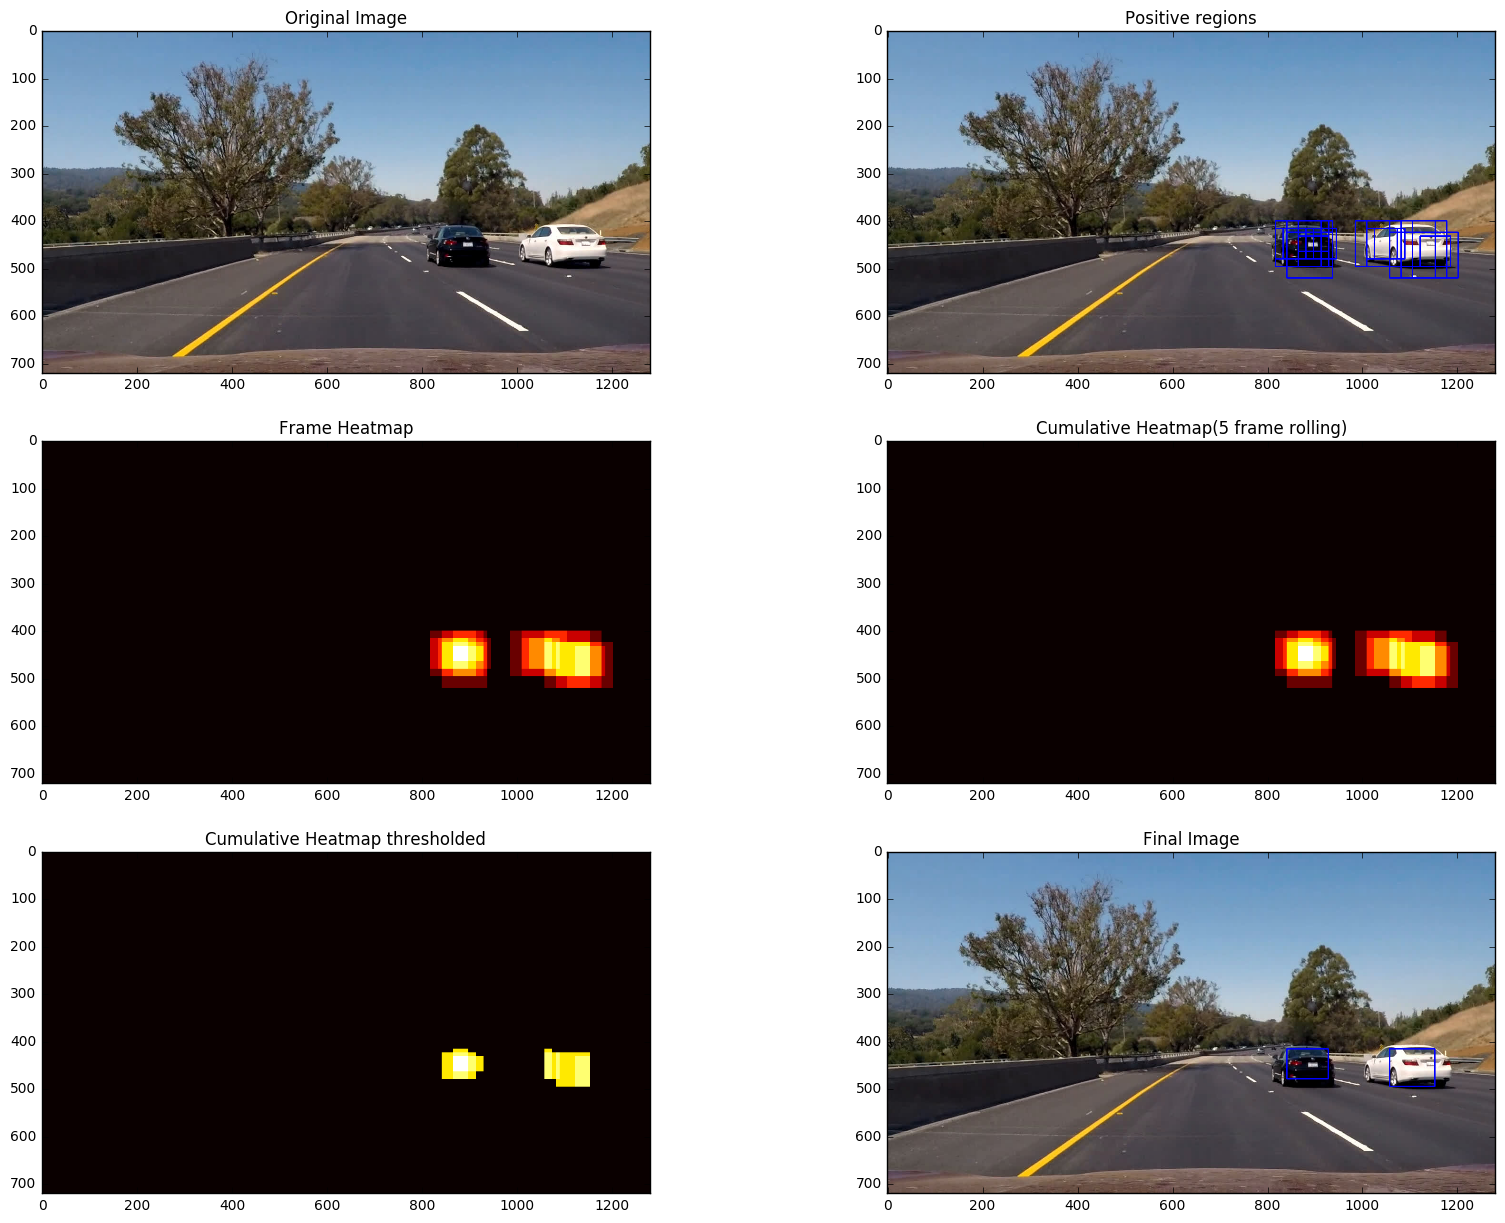

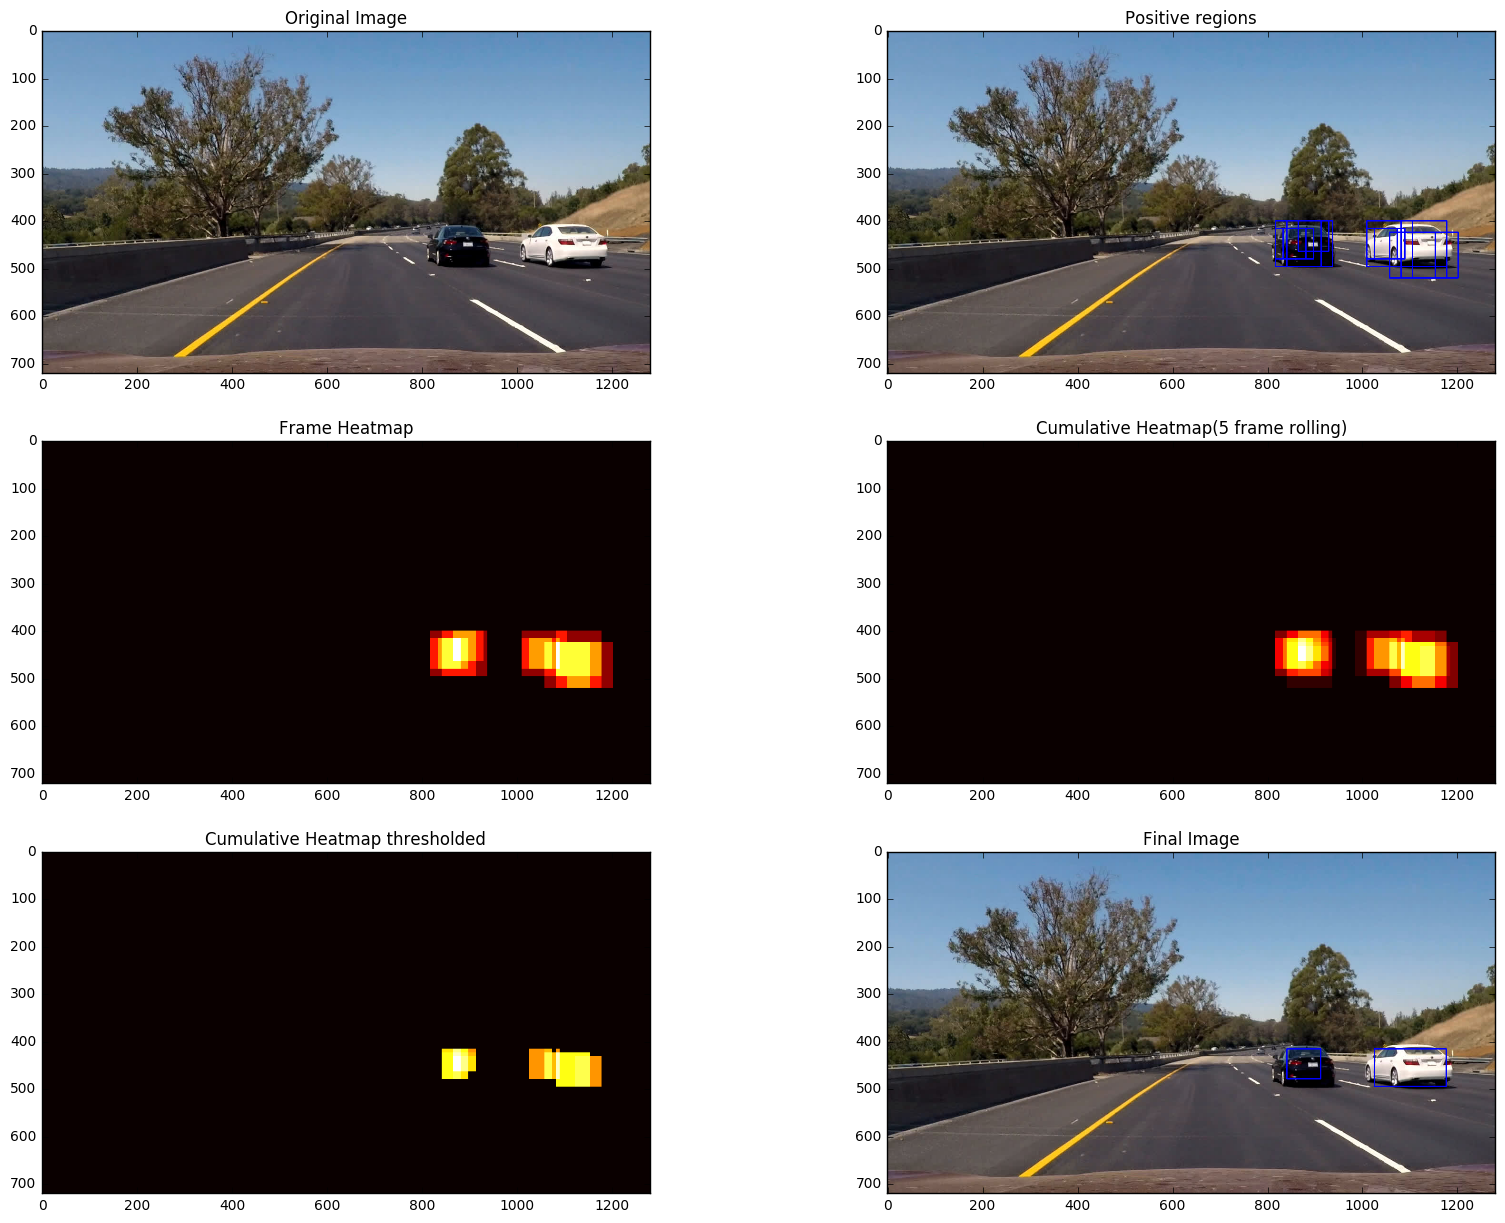

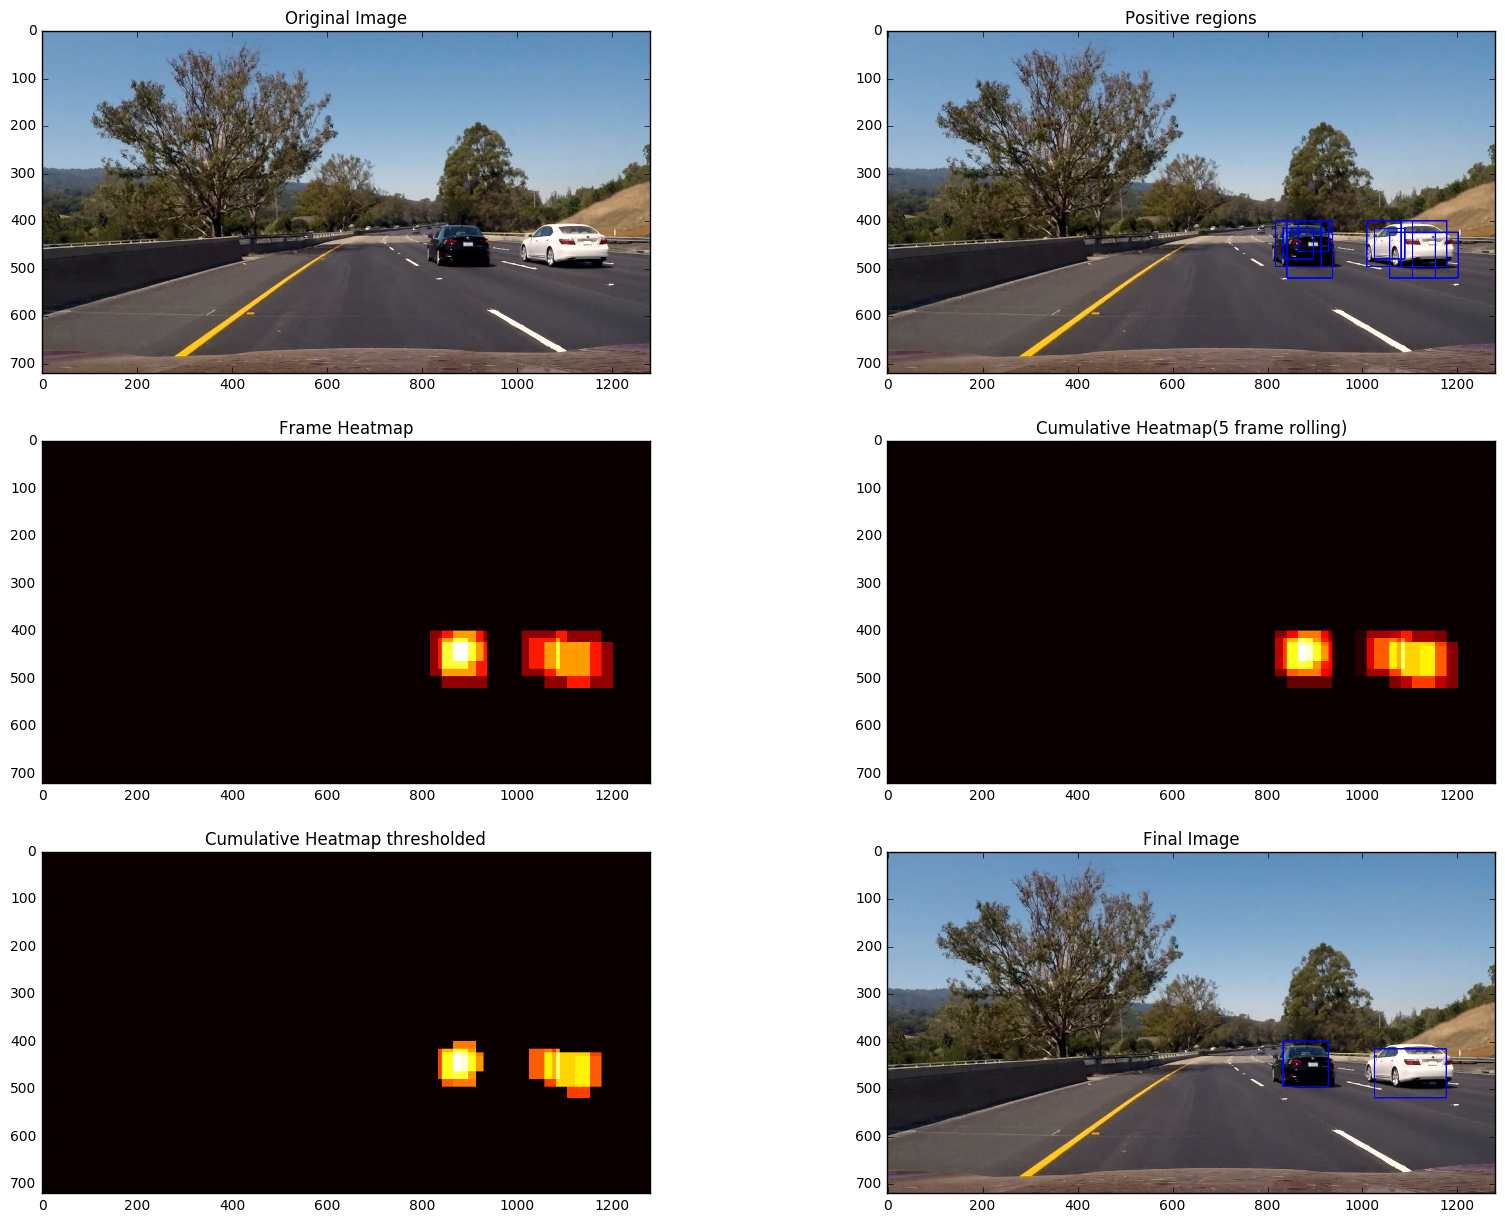

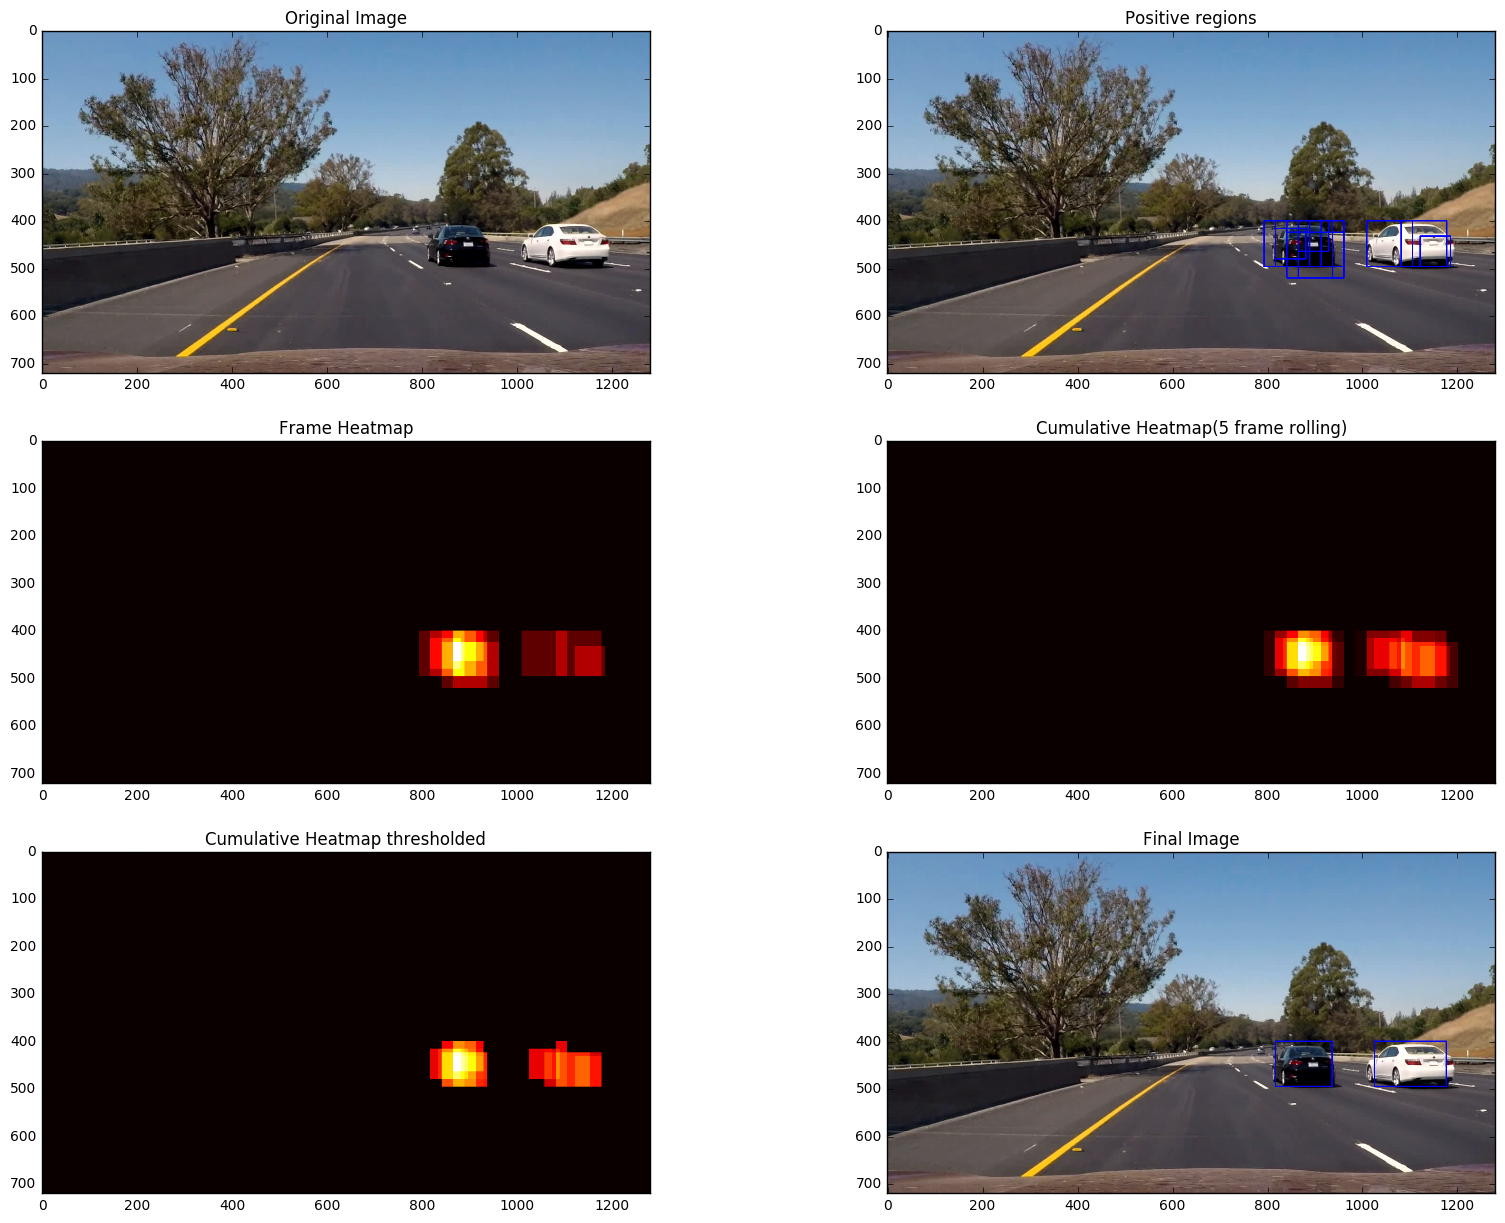

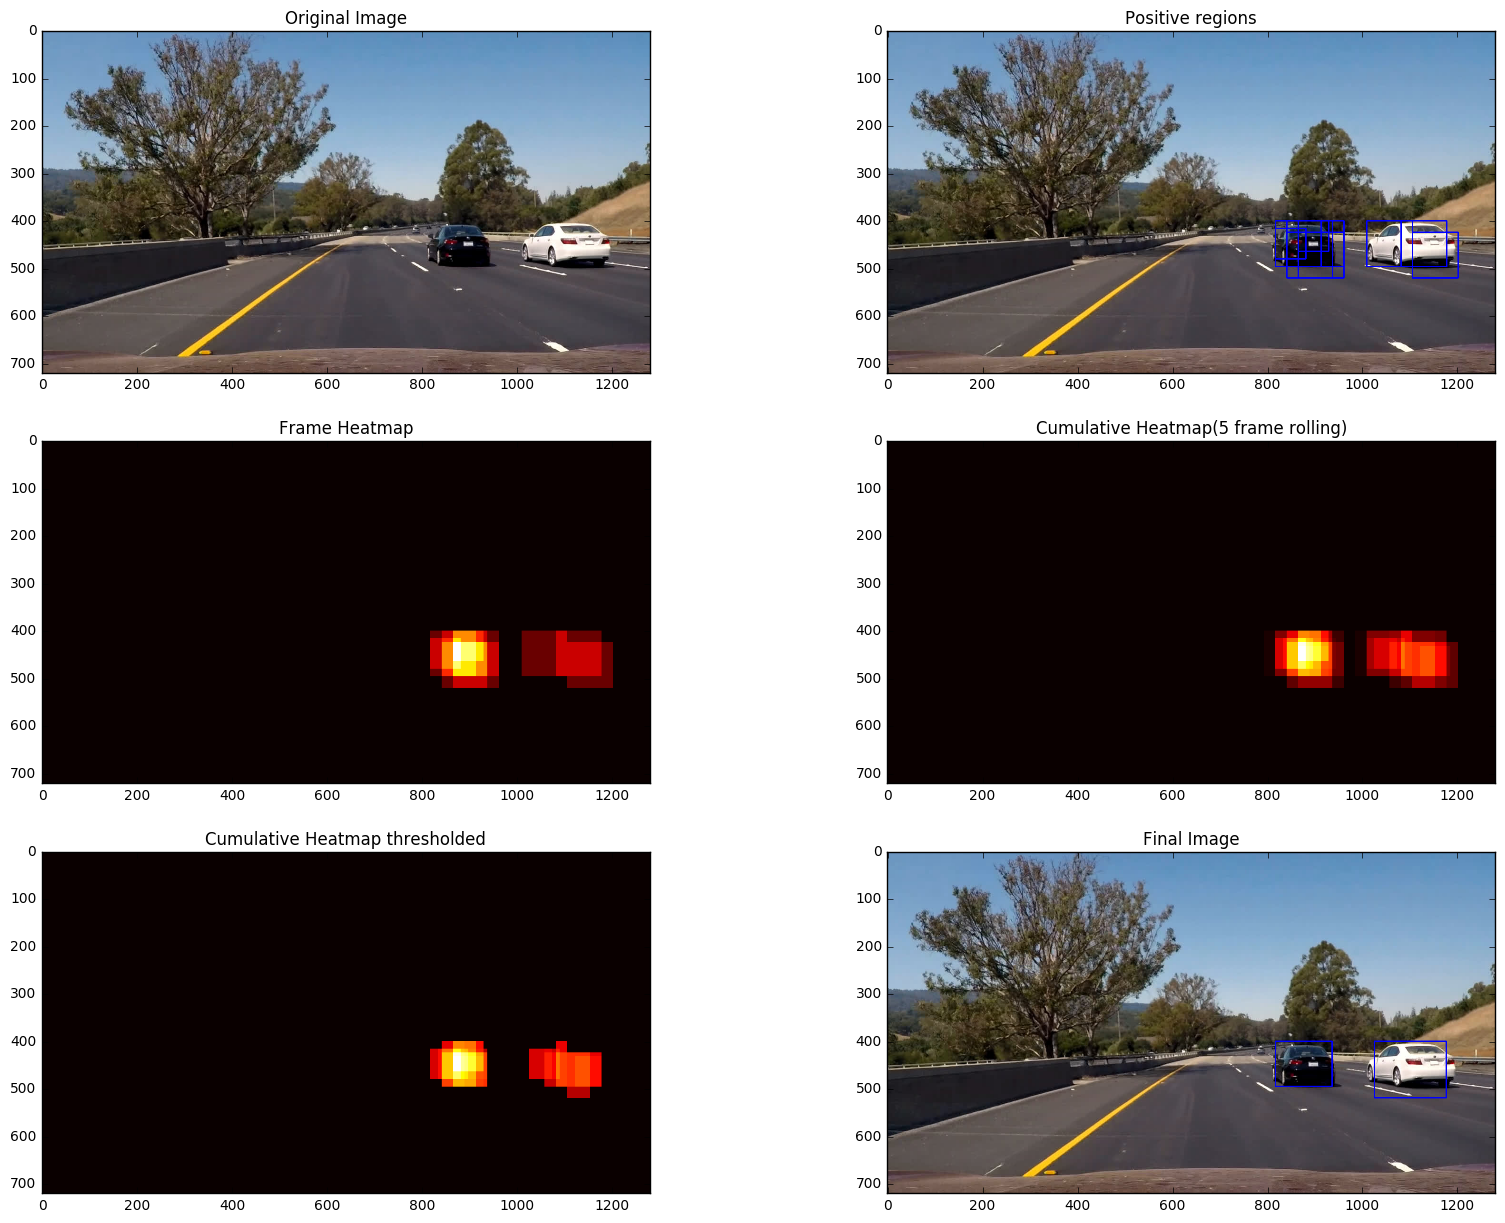

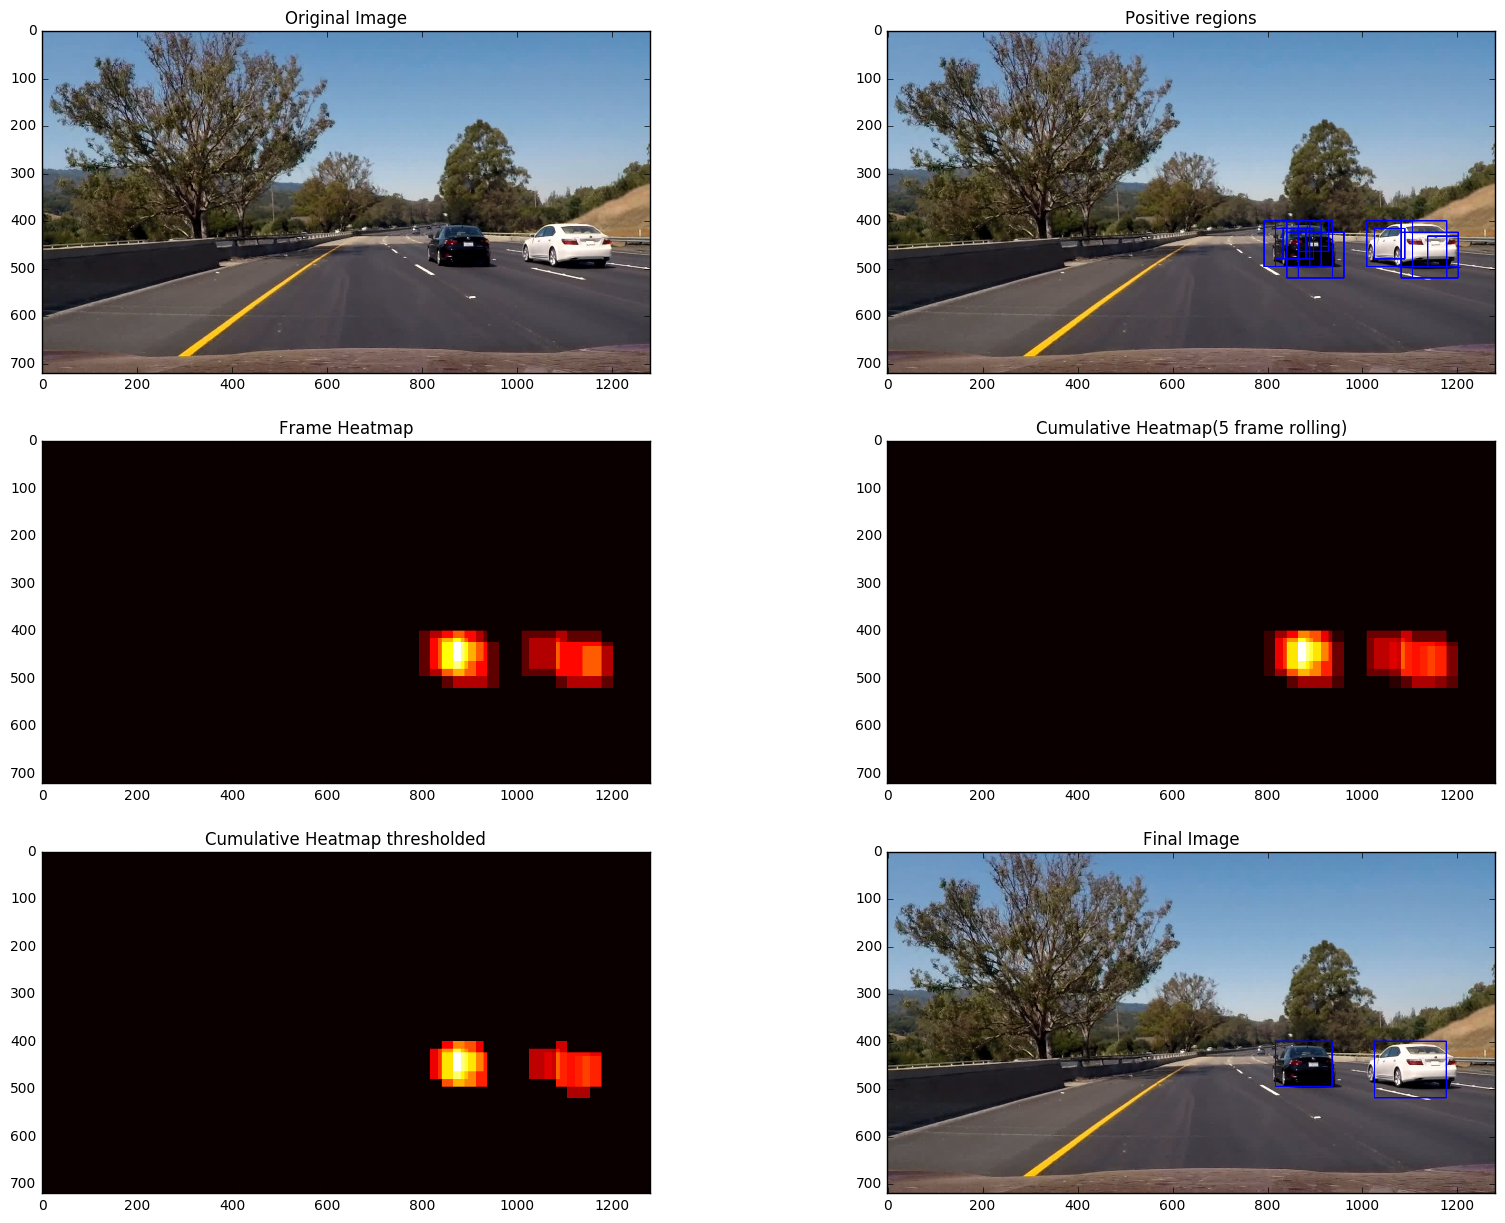

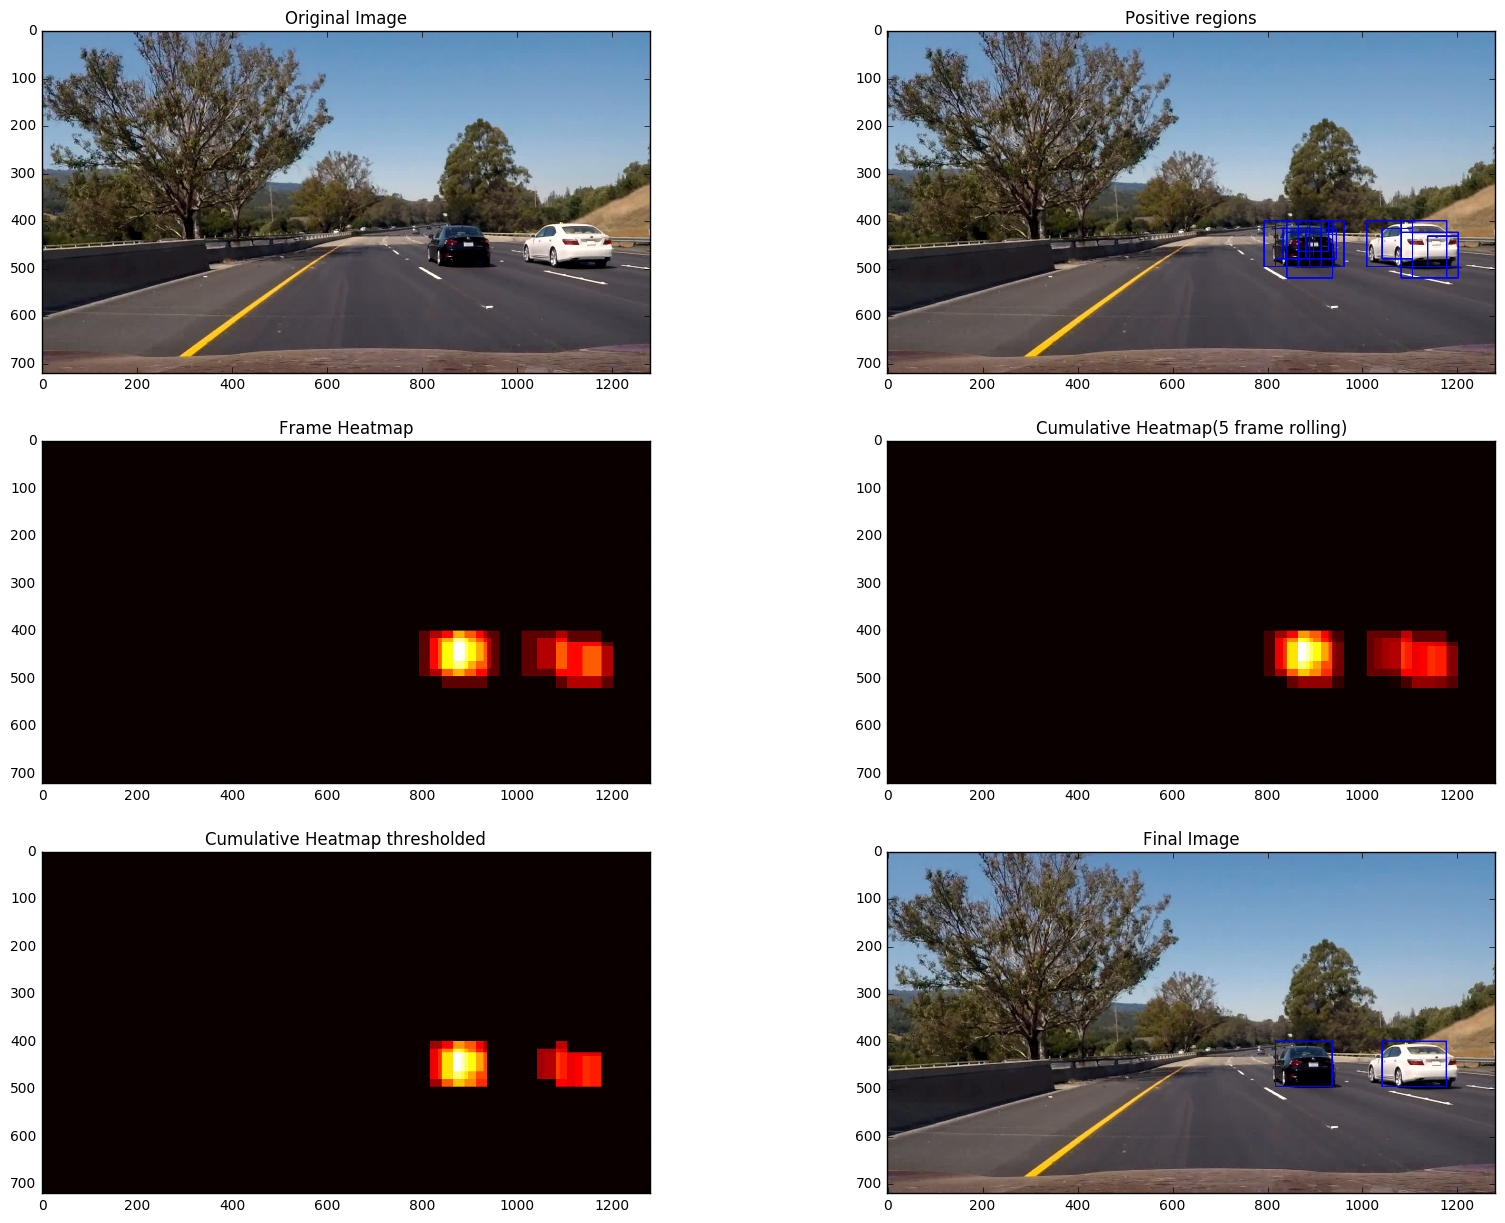

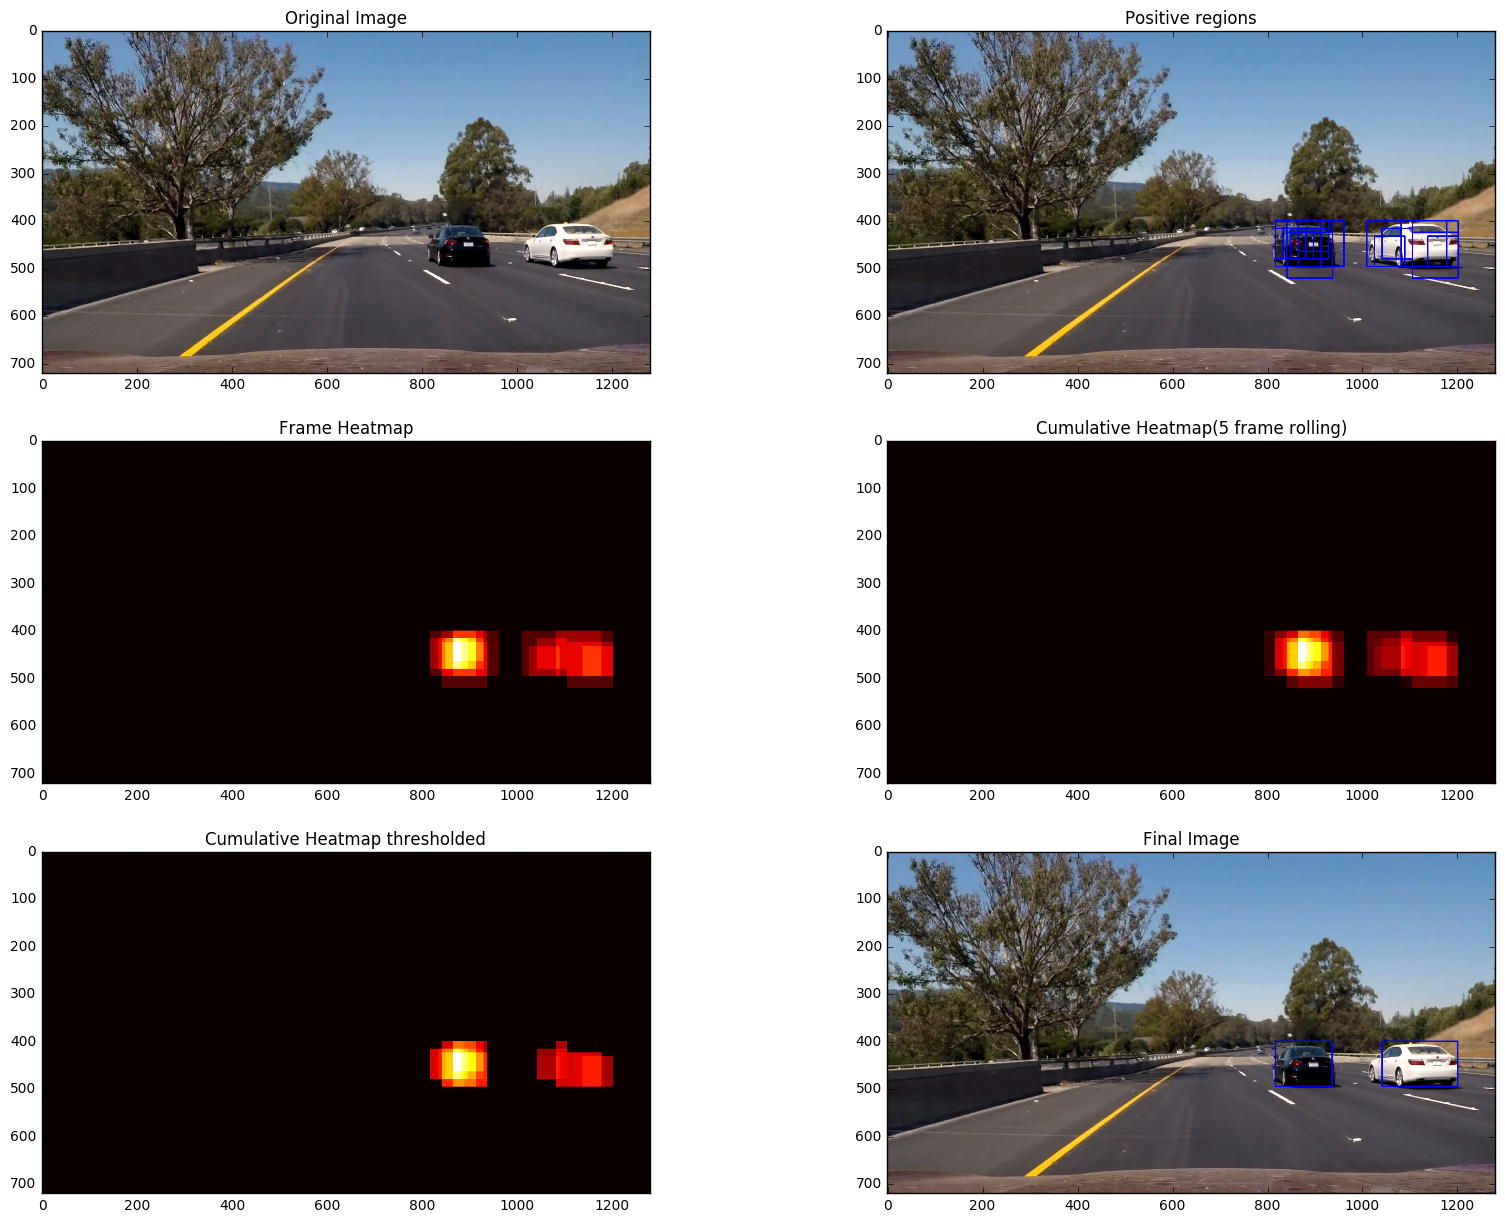

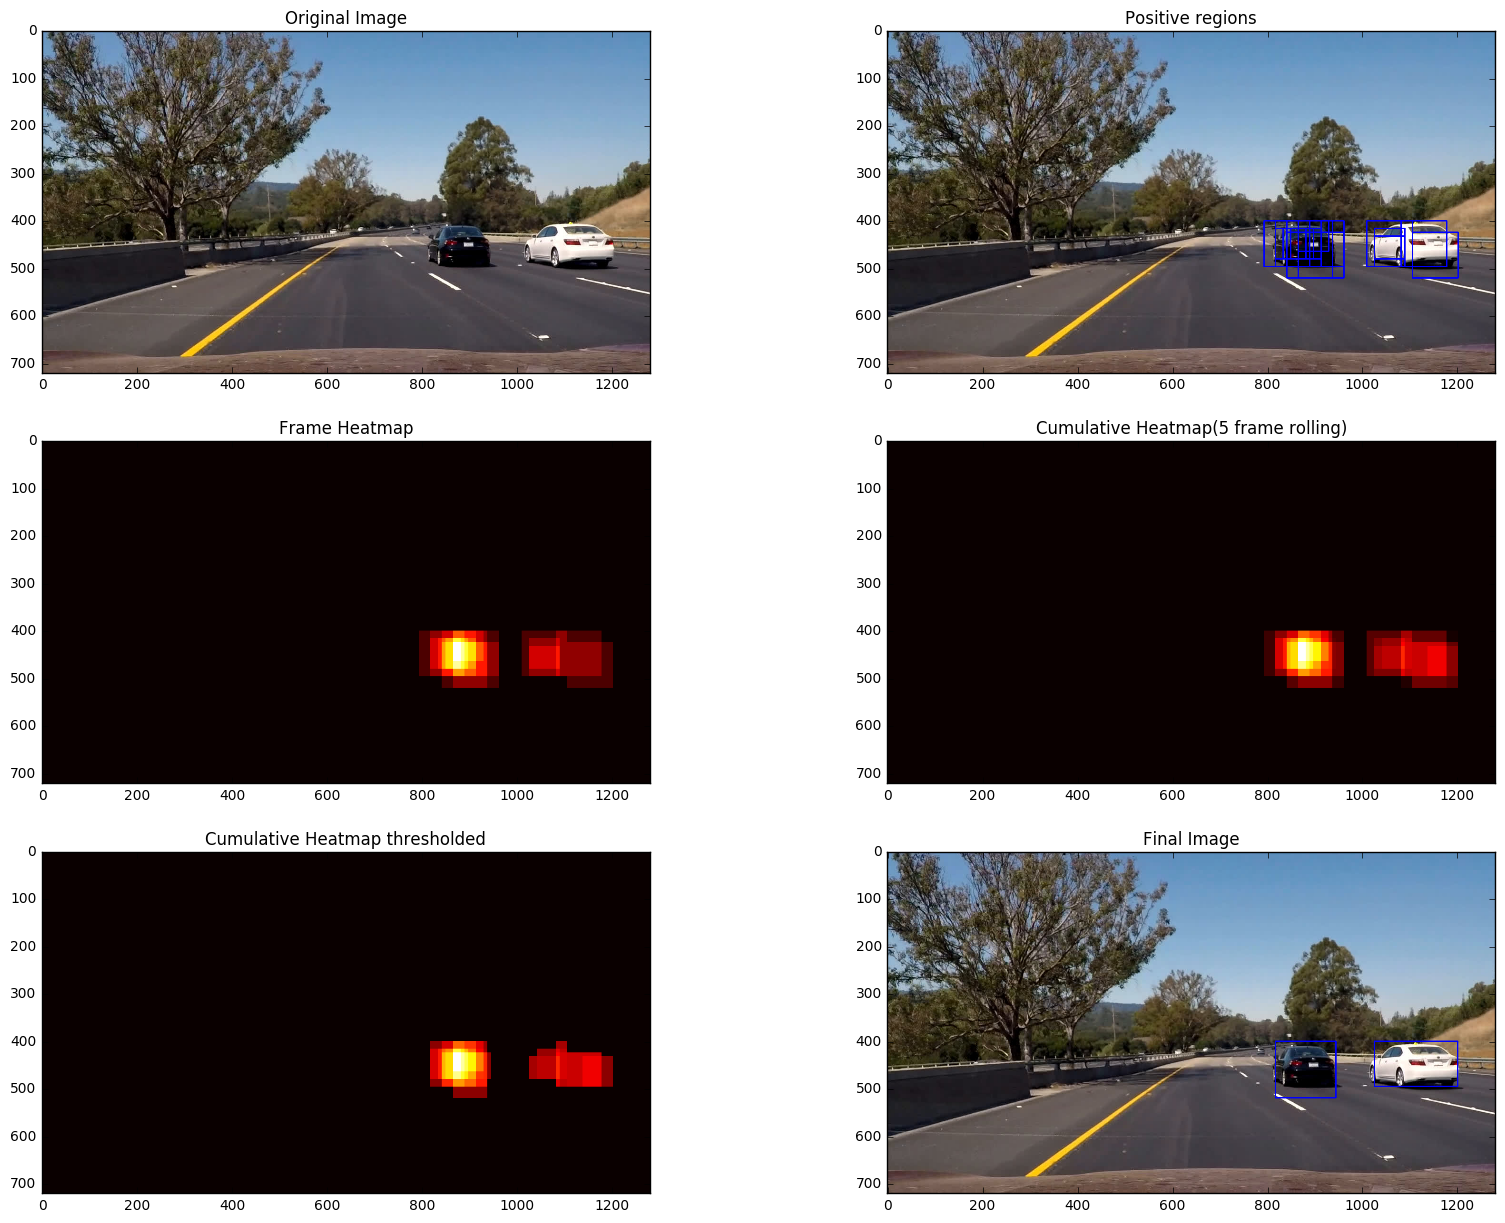

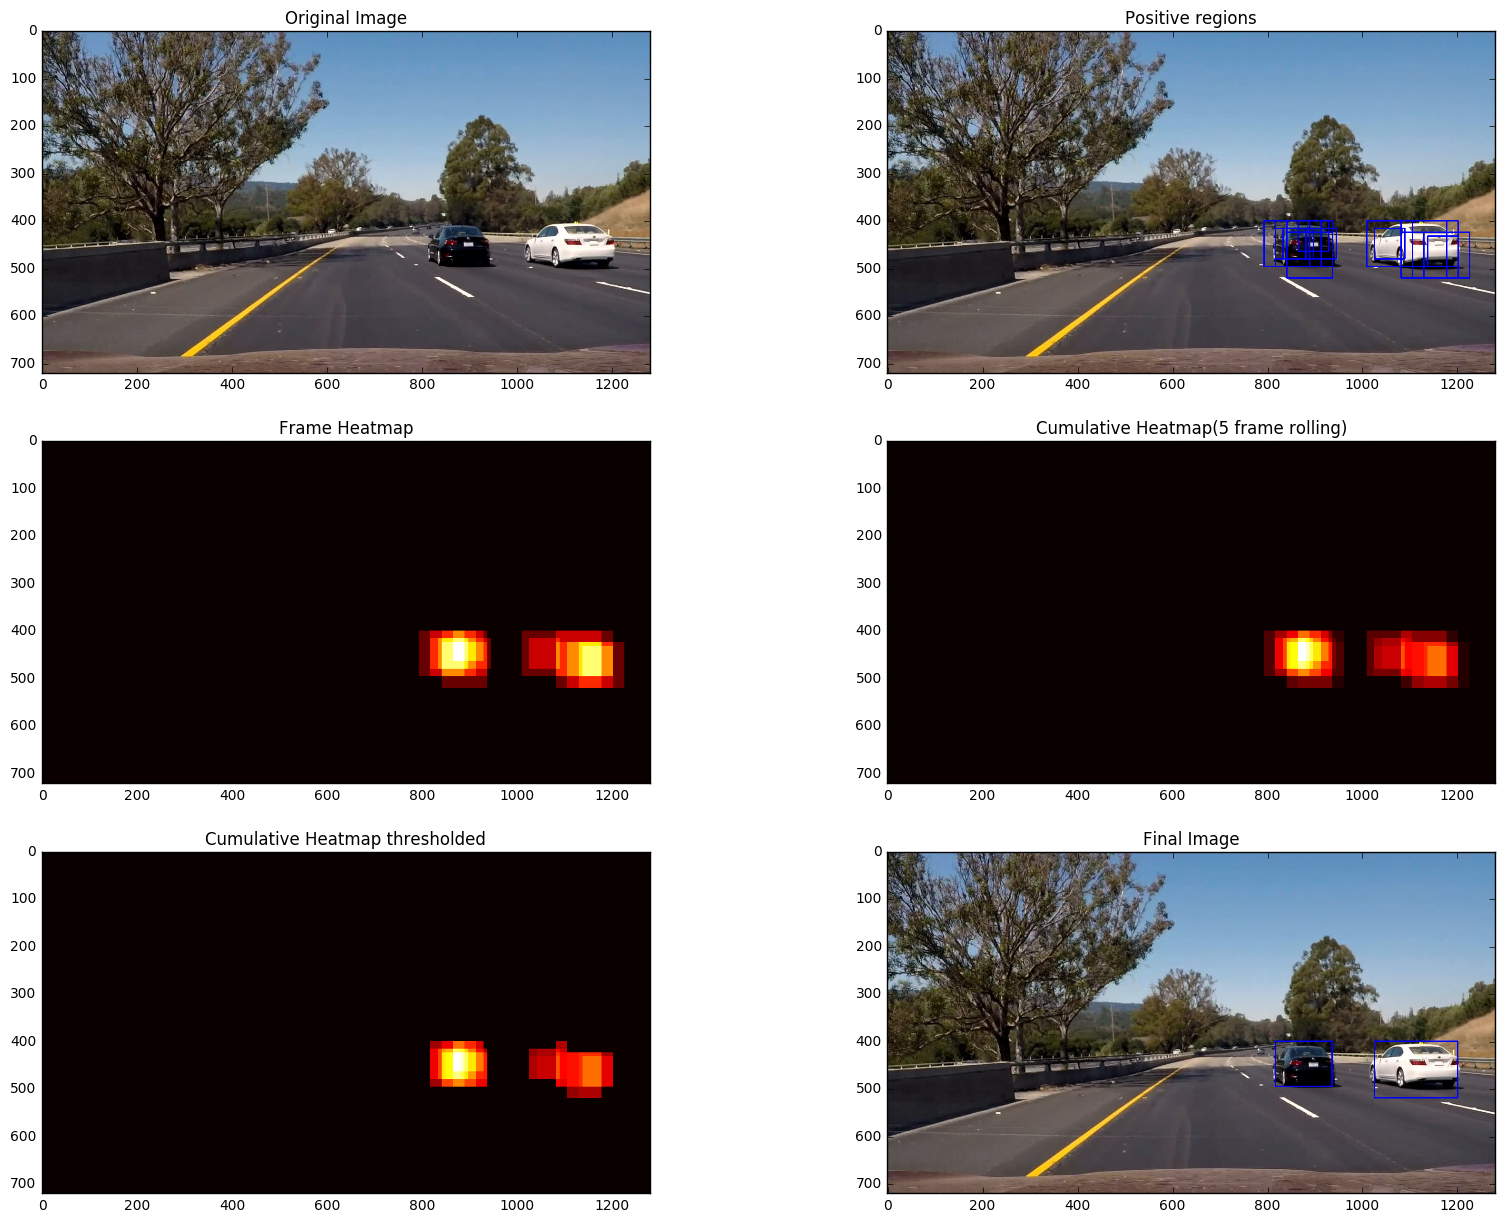

In [12]:
# run pipeline on 10 image pipeline
# parameters for search window and visualaization of pipeline
track_frames = True
window_scales = [1, 1.5]
threshold=9
visualize=True
color=(0, 0, 255)
thick=2

images = []
for i in range(960,970):
    images.append('./new_samples/0'+str(i)+'.jpg')

#images = glob.glob('./test_images/*.jpg')

    
trackmaps = TrackHeatMaps(n=5)

for f in images:
    img = mpimg.imread(f)
    process_img(img)


In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
# parameters for search window and visualaization of pipeline
track_frames = True
window_scales = [1, 1.5]
threshold=9
visualize=False
color=(0, 0, 255)
thick=2

# Run pipeline
trackmaps = TrackHeatMaps(n=5)
video_output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')
output_clip = clip.fl_image(process_img)
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [29:28<00:01,  1.32s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 29min 29s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

### Now we add pipeline from Project 4 - Lane Identification

In [16]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #no of history data
        self.n = 5
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients from last n iterations
        self.last_n_fit = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None



def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

# this pipeline takes the original image and
# applies a combined gradient and S channel thresholding
# imgae is supposed be read with imread giving RGB colors
def threshold_fn(img, sobel_kernel=3, s_thresh=(170, 220), mag_thresh=(20, 100)):
    img = np.copy(img)
    
    #Do Sobel_mag
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # removed sobely after trial and error
    gradmag = np.sqrt(sobelx**2 + sobely**2*0)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    grad_binary = np.zeros_like(gradmag)
    grad_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    #Do S channel Thresholding
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    #Combine two binary thresholds
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(grad_binary == 1) | (s_binary == 1)] = 1

    return combined_binary

def apply_perspective(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
    return warped


def initial_lane_centers(h):
    midp = np.int(h.shape[0]/2)
    lc = np.argmax(h[:midp])
    rc = np.argmax(h[midp:])+midp
    return (lc, rc)

# original sliding window which uses single row as window height
def sliding_windows_one_row(src, dst, mid, win_size=25):
    for row in range(src.shape[0]-1,-1,-1):
        st = max(0,mid-win_size)
        end = min(mid+win_size, src.shape[1]-1)
        dst[row,st:end] = src[row,st:end]
        ones = np.where(src[row,st:end] == 1)
        if len(ones[0]):
            mid = np.int(np.mean(ones)+st)

def sliding_windows(src, dst, mid, win_size=50, win_height=60):
    for row in range(src.shape[0],0,-win_height):
        st = max(0,mid-win_size)
        end = min(mid+win_size, src.shape[1]-1)
        dst[max(0,row-win_height):row, st:end] = src[max(0,row-win_height):row, st:end]
        ones = np.where(src[max(0,row-win_height):row, st:end] == 1)
        # ones will be a tuple where first element i.e. ones[0] is the y indices of non zero elments and 2nd element i.e. ones[1] is
        # x indicies of non zero values. We will extract only the 2nd element and take an average to findd the 
        # x center of slice
        if len(ones[1]):
            mid = np.int(np.mean(ones[1])+st)
            
            
def isolate_lanes(img, left_line, right_line, reinitiate=True):
    warped = np.copy(img)
    if reinitiate:
        histogram = np.sum(warped[warped.shape[0]/3:,:], axis=0)
        lc, rc = initial_lane_centers(histogram)
    else:
        yval = warped.shape[0]-1
        lc = left_line.best_fit[0]*yval**2+left_line.best_fit[1]*yval+left_line.best_fit[2]
        rc = right_line.best_fit[0]*yval**2+right_line.best_fit[1]*yval+right_line.best_fit[2]
        
    lines = np.zeros_like(warped)
    sliding_windows(warped, lines, lc)
    sliding_windows(warped, lines, rc)
    return lines

def detect_line(points, is_left_ln):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension

    # mid point on x-axis
    midx = np.int(points.shape[1]/2)
    # values from 0 to 719 - the nmber of pixels of the height of image
    yvals = np.linspace(0, points.shape[0]-1,points.shape[0])
    ln_pts = np.where(points==1) #returns the tuple with first element all the y and 2nd all the x
    # fit a degree 2 polynomial
    # usually atleast few points must be returned, however, in extreme case it does not happen, we return junk values
    if len(ln_pts[1])>0:
        fit = np.polyfit(ln_pts[0], ln_pts[1], 2)
        fitx = fit[0]*yvals**2 + fit[1]*yvals + fit[2]

        #find error in estimation and coffcient of determination
        x_est = fit[0]*ln_pts[0]**2 + fit[1]*ln_pts[0] + fit[2]
        fit_coeff = 1 - np.sum((x_est - ln_pts[1])**2) / np.sum((ln_pts[1] - np.mean(ln_pts[1]))**2)

        # curvature in meters
        fit_cr = np.polyfit(ln_pts[0]*ym_per_pix, ln_pts[1]*xm_per_pix, 2)
        y_eval = np.max(yvals)
        curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) /np.absolute(2*fit_cr[0])

        # offset of vehicle from center of lane
        if is_left_ln:
            _base_pos = 350 - abs(fitx[-1] - midx)  #350 is half of lane width in pixels
        else:
            _base_pos = abs(fitx[-1] - midx) - 350 
        #convert pixels to meters    
        _base_pos = _base_pos * xm_per_pix

        return (fit_coeff, fitx, fit, curverad, _base_pos, ln_pts[1], ln_pts[0])
    else:
        #return junk values if the input set of pixels is an empty array
        return (0,yvals, [0,0,0], 0, 0, np.array([0]), np.array([0]))
    

def fit_poly(lane_img, left_line, right_line, video_clip=False):
    if left_line == None or right_line == None:
        print("Lines can't be null. Check code")
        
    global bad_frames_cnt


    # mid point on x axis to divide the image into two halfs
    midx = np.int(lane_img.shape[1]/2)
    
    #retain only left half pixels in image
    left_lane_img = np.copy(lane_img)
    left_lane_img[:,midx:] = 0

    #retain only right half pixels in image
    right_lane_img = np.copy(lane_img)
    right_lane_img[:, :midx] = 0
    
    #process each image to collect the data
    l_fit_coeff, l_fitx, l_fit, l_curverad, l_base_pos, l_x, l_y = detect_line(left_lane_img, is_left_ln=True)
    r_fit_coeff, r_fitx, r_fit, r_curverad, r_base_pos, r_x, r_y = detect_line(right_lane_img, is_left_ln=False)
    #print(l_fit_coeff, r_fit_coeff)
        
    #now we should do sanity check of two detections and then decide to store the lines
    # check closeness of curvature - valid only if two line detections have high r2
    similar_curvature = abs(l_curverad - r_curverad) / (abs(l_curverad + r_curverad)/2) < 0.30

    # check if fitted lines are kind of parallel 
    # i.e. the separation at top and bottom are within 20%
    top_separation = r_fitx[0] - l_fitx[0]
    bottom_seaparation = r_fitx[-1] - l_fitx[-1]
    is_parallel =  abs(top_separation - bottom_seaparation) / (abs(top_separation + bottom_seaparation)/2) < 0.30
    
    #if both lines have high r2 and have similar curvature and kind of parallel
    if video_clip and similar_curvature and is_parallel:
        #lane found is good
        left_line.detected = True
        if len(left_line.recent_xfitted) != 0:
            left_line.recent_xfitted = np.vstack((l_fitx, left_line.recent_xfitted))[0:left_line.n+1]
        else:
            left_line.recent_xfitted = np.reshape(l_fitx,(1,-1))
        left_line.bestx = np.mean(left_line.recent_xfitted, axis=0)
        prev_l_fit = left_line.current_fit
        left_line.current_fit = l_fit
        if prev_l_fit != None:
            left_line.diffs = l_fit - prev_l_fit
        if len(left_line.last_n_fit) != 0: 
            left_line.last_n_fit = np.vstack((left_line.current_fit, left_line.last_n_fit))[0:left_line.n+1]
        else:
            left_line.last_n_fit = np.reshape(l_fit, (1,-1))
        left_line.best_fit = np.mean(left_line.last_n_fit, axis=0)
        left_line.radius_of_curvature = l_curverad
        left_line.line_base_pos = l_base_pos
        left_line.allx = l_x
        left_line.ally = l_y
        
        right_line.detected = True
        if len(right_line.recent_xfitted) != 0:
            right_line.recent_xfitted = np.vstack((r_fitx, right_line.recent_xfitted))[0:right_line.n+1]
        else:
            right_line.recent_xfitted = np.reshape(r_fitx,(1,-1))
        right_line.bestx = np.mean(right_line.recent_xfitted, axis=0)
        prev_r_fit = right_line.current_fit
        right_line.current_fit = r_fit
        if prev_r_fit != None:
            right_line.diffs = r_fit - prev_r_fit
        if len(right_line.last_n_fit) != 0: 
            right_line.last_n_fit = np.vstack((right_line.current_fit, right_line.last_n_fit))[0:right_line.n+1]
        else:
            right_line.last_n_fit = np.reshape(r_fit, (1,-1))
        right_line.best_fit = np.mean(right_line.last_n_fit, axis=0)
        right_line.radius_of_curvature = r_curverad
        right_line.line_base_pos = r_base_pos
        right_line.allx = r_x
        right_line.ally = r_y
        bad_frames_cnt = 0
        
    else:
        
        left_line.detected = False
        right_line.detected = False
        bad_frames_cnt = bad_frames_cnt+1
        
    if left_line.best_fit != None and right_line.best_fit != None and video_clip:
        return (left_line.best_fit, left_line.radius_of_curvature, right_line.best_fit, right_line.radius_of_curvature, 
                (left_line.line_base_pos+right_line.line_base_pos)/2, l_x, l_y, r_x, r_y)    
    else:
        return (l_fit, l_curverad, r_fit, r_curverad, 
                (l_base_pos+r_base_pos)/2, l_x, l_y, r_x, r_y)

def merge_lane(undist, warped, Minv, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    yvals = np.linspace(0,warp_zero.shape[0]-1,warp_zero.shape[0])
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def annotate(org_img, left_curvature, right_curvature, offset):
    img = np.copy(org_img)
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (255,255,255)
    curvature_text = 'Curvature: Left = {:.2f} m and Right = {:.2f} m'.format(left_curvature, right_curvature)
    if offset < 0:
        offset_text = 'Lane Position: {:.2f} m left of center'.format(abs(offset))
    else:
        offset_text = 'Lane Position: {:.2f} m right of center'.format(abs(offset))
    
    cv2.putText(img, curvature_text, (10,30), font, 1, color, 2)
    cv2.putText(img, offset_text, (10,70), font, 1, color, 2)
    return img
    

# some functions from vehicle detection pipeline modifed to return just 
# labeled boxes so that those can be drawn on top of lane detected image
def get_labeled_bboxes(img, heatmap, color=(0, 0, 255), thick=6):
    # Iterate through all detected cars
    labels = label(heatmap)
    bboxes=[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        bboxes.append(bbox)
    # Return the image
    return bboxes


    
def pipeline_vehicle(img, clf, scaler, color_space='RGB', hog_space='RGB', img_type='JPG',
                    track_frames = False, window_scales=[1], spatial_size=(32, 32), hist_bins=32, 
                    orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True, color=(0,0,255), thick=6, threshold=2, visualize=True):

    # trackmaps is a global variable
    global trackmaps
    
    # check if image needs scaling based on img_type
    result_img = np.copy(img)
    if img_type == 'PNG':
        result_img = (result_img*255).astype(np.uint8)
        #result_img = result_img.astype(np.float32)/255 # Need to be scaled to 0-1 
    # search over all windows, extracting the image for window region and then run classifier to check
    # if window is hot
    all_windows, hot_windows = search_windows(result_img, clf=clf, scaler=scaler, color_space=color_space, hog_space=hog_space,
                        window_scales=window_scales, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    heatmap = get_heat(img, hot_windows)
    if track_frames:
        trackmaps.add_row(heatmap)
        # get heatmap for hot windows across frames
        for h_map in trackmaps.last_n_frames:
            heatmap+= h_map
    
    #apply threholding to remove False Positives
    thresholded_heatmap = apply_threshold(heatmap, threshold=threshold)

    #draw labeled boxes to merge multiple detections into a single rectangle
    labeled_boxes = get_labeled_bboxes(np.copy(img), thresholded_heatmap, color=color, thick=thick)

        
    return labeled_boxes


def pipeline_combined(img, mtx, dist, M, Minv, left_line, right_line, plot_result=False, video_clip=False, clf=model, scaler=scaler, color_space=color_space, 
                    hog_space=hog_space, img_type='JPG',
                    track_frames=track_frames, window_scales=window_scales,
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat, color=color, thick=thick, threshold=threshold, visualize=visualize):
    #undistort
    undist = undistort(img, mtx, dist)
    #threshold
    thresh = threshold_fn(undist)
    # Do perspective Tranform
    warped = apply_perspective(thresh, M)
    #isolate lane lines and find curvature
    global bad_frames_cnt
        
    if video_clip and bad_frames_cnt < 7 and left_line.best_fit != None and right_line.best_fit != None:
        warped_lanes = isolate_lanes(warped, left_line, right_line, reinitiate=False)
    else:
        warped_lanes = isolate_lanes(warped, left_line, right_line, reinitiate=True)
        bad_frames_cnt = 0
        
    #do fit and find curvature
    left_fit, left_curverad, right_fit, right_curverad, offset, l_x, l_y, r_x, r_y = \
        fit_poly(warped_lanes, left_line, right_line, video_clip)
    #draw polyfill on warped image and reverse the perspective to original
    lane_fitted_img = merge_lane(undist, warped, Minv, left_fit, right_fit)
    
    #annotate
    annotated_img = annotate(lane_fitted_img, left_curverad, right_curverad, offset)

    # vehicle detection pipeline
    labeled_boxes = pipeline_vehicle(
                    img, clf=model, scaler=scaler, color_space=color_space, 
                    hog_space=hog_space, img_type='JPG',
                    track_frames=track_frames, window_scales=window_scales,
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat, color=color, thick=thick, threshold=threshold, visualize=visualize)

    
    combined_img = draw_boxes(annotated_img, labeled_boxes, color=color, thick=thick)
    #return lane fitted and annotated image
    return combined_img
    
    



In [17]:
# Global variables for lane finding
left_line = Line()
right_line = Line()
bad_frames_cnt = 0

# Read in the saved distortion coefficients
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# read in saved M and Minv
M_pickle = pickle.load( open( "M_pickle.p", "rb" ) )
M = M_pickle["M"]
Minv = M_pickle["Minv"]

# Params for Vehcile detection
track_frames = True
window_scales = [1, 1.5]
threshold=9
visualize=False
color=(0, 0, 255)
thick=2

# Global variable for vehicle detection to keep track of vehicles detcted across multiple frames
trackmaps = TrackHeatMaps(n=5)


def process_image_combined(img):
    return pipeline_combined(img, mtx, dist, M, Minv, left_line, right_line, plot_result=False, video_clip=True, clf=model, scaler=scaler, color_space=color_space, 
                    hog_space=hog_space, img_type='JPG',
                    track_frames=track_frames, window_scales=window_scales,
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat, color=color, thick=thick, threshold=threshold, visualize=visualize)

In [21]:
video_output_combined = 'project_video_output_combined.mp4'
output_clip_combined = clip.fl_image(process_image_combined)
%time output_clip_combined.write_videofile(video_output_combined, audio=False)

[MoviePy] >>>> Building video project_video_output_combined.mp4
[MoviePy] Writing video project_video_output_combined.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [30:27<00:01,  1.43s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_combined.mp4 

Wall time: 30min 29s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output_combined))